### Torchvison transform

In [ ]:
import detection_transforms as dt
from data import BedsoreDataset
from utils import draw_bbox
import torch
import random
from torchvision import transforms

In [2]:
# tfmc = Compose([RandomCrop(), ToTensor()])
# tfmc = Compose([])

trans_prob = 0.5
tfmc = dt.Compose([
            dt.RandomCrop(1),
            dt.RandomGaussianBlur((0.1,1),1),
             dt.RandomColorJitter(trans_prob),
            (dt.RandomHorizontalFlip(0.8), dt.RandomVerticalFlip(0.8), dt.RandomRotate(0.8)),
            dt.RandomResize(trans_prob),
            dt.ToTensor(),
            dt.RandomErasing(),
        ])

ds = BedsoreDataset('data', transforms=tfmc)

In [5]:
ds[33]

TypeError: __call__() got an unexpected keyword argument 'bboxes'

In [6]:
%debug

> /home/zrway/Projects/Bedsore/data.py(93)__getitem__()
     91 
     92         if self.transforms is not None:
---> 93             transformed = self.transforms(image=np.array(image), bboxes=target['boxes'], mask=target['masks'].permute(1, 2, 0).numpy(), category_ids=target['labels'])
     94             image = transformed['image']
     95             target['boxes'] = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)



ipdb>  image


<PIL.Image.Image image mode=RGB size=3024x4032 at 0x7FE32C0AC450>


ipdb>  bboxes


*** NameError: name 'bboxes' is not defined


ipdb>  target


{'boxes': tensor([[1409.5713, 1006.3711, 2500.4414, 2109.2949]]), 'labels': tensor([4]), 'image_id': tensor([33]), 'fname': 'B01_00048', 'masks': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])}


ipdb>  target['boxes']


tensor([[1409.5713, 1006.3711, 2500.4414, 2109.2949]])


ipdb>  target['labels']


tensor([4])
--KeyboardInterrupt--


ipdb>  q


In [4]:
image,target = ds[33]
draw_bbox(image,target)

TypeError: __call__() got an unexpected keyword argument 'bboxes'

In [ ]:
image,target = ds[1]
W,H = image.size
# _, H,W = image.size()
min_minx = target['boxes'][:,0].min()
min_miny = target['boxes'][:,1].min()
min_maxx = target['boxes'][:,2].max()
min_maxy = target['boxes'][:,3].max()
a = int(random.uniform(0,min_minx))
b = int(random.uniform(0,min_miny))
c = int(random.uniform(min_maxx,W))
d = int(random.uniform(min_maxy,H))
target['boxes'][:,0] -= a
target['boxes'][:,2] -= a
target['boxes'][:,1] -= b
target['boxes'][:,3] -= b

a,b,c,d

In [155]:
image_cropped = image.crop((a,b,c,d))

In [ ]:
image_cropped = transforms.ToTensor()(image_cropped)
draw_bbox(image_cropped,target)

### Album

In [1]:
import albumentations as A
from data import BedsoreDataset
from utils import draw_bbox
from torchvision import transforms as T
import numpy as np
from albumentations.pytorch import ToTensorV2,ToTensor
import torch
from utils import batch2pil, draw_bbox, out2detfile
from PIL import Image
from tqdm import tqdm

In [331]:
atfmc = A.Compose([
#     A.RandomScale(p=1,scale_limit=(-0.5,-0.5)),
    A.RandomSizedBBoxSafeCrop(800,800,erosion_rate=0.2,p=0.5),
#     A.RandomSizedBBoxSafeCrop(512,512,0.5),
#     A.RandomShadow(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5,scale_limit=0.5,rotate_limit=360,border_mode=0),
    A.RandomBrightnessContrast(p=0.5),
#     A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.3),
    ToTensor(),
    ],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))


# atfmc = A.Compose([
#     ToTensor(),
#     ],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))

ds = BedsoreDataset('data', transforms=atfmc)
ids = 1155
image,target = ds[ids]
print(image.shape)

SZ = 256
ry = Image.new("RGB",(SZ,SZ),(255,0,0))
fr = Image.new("RGB",(SZ,SZ),(255,255,0))
hs = Image.new("RGB",(SZ,SZ),(0,0,255))
tissue = {7:hs, 8:fr, 9:ry}

torch.Size([3, 800, 800])


B06_00173


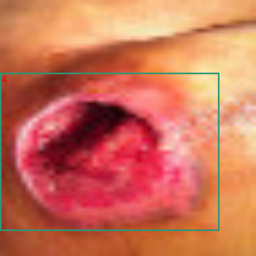

In [332]:
print(target['fname'])
good_labels = target['labels']
good_masks = target['masks'][good_labels>6]
good_labels = good_labels[good_labels>6]
img_out = draw_bbox(image,target).resize((SZ,SZ))

for i,t in enumerate(good_labels):
    mask = batch2pil(((good_masks[i])>0.5).float()).resize((SZ,SZ))
    mask = np.array(mask)*0.5
    mask = Image.fromarray(mask.astype('uint8')).convert('L')
    img_out = Image.composite(tissue[t.item()], img_out, mask)
    
img_out

### 遍历检查脚本

In [5]:
#  for i in tqdm(range(0,len(ds))):
#     image,target = ds[i]
# #     print(i,target['fname'])
    
#     good_labels = target['labels']
#     good_masks = target['masks'][good_labels>6]
#     good_labels = good_labels[good_labels>6]
#     img_out = draw_bbox(image,target).resize((SZ,SZ))

#     for i,t in enumerate(good_labels):
#         mask = batch2pil(((good_masks[i])>0.5).float()).resize((SZ,SZ))
#         mask = np.array(mask)*0.5
#         mask = Image.fromarray(mask.astype('uint8')).convert('L')
#         img_out = Image.composite(tissue[t.item()], img_out, mask)
#     img_out.save(f"check_image/{target['fname']}.jpg")

100%|██████████| 1363/1363 [10:29<00:00,  2.17it/s]
